In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import pandas as pd
import sys
import yaml
import math
import glob
import os
from ncar_branding import *


if __name__ == "__main__" and "__file__" not in globals():
    sys.argv[1] = 'derecho.yaml'
    
with open(sys.argv[1], 'r') as flh:
   mach = yaml.safe_load(flh)

secsinaday = 24 * 60 * 60
acctdir = mach['acctdir']
coresinnode = mach['corespnode']
numnodes = mach['numnodes']
gpusinnode = mach['gpuspnode']
numgpunodes = mach['numgpunodes']

label=hrtype=hrlabel=hrsuffix=normfactor=tumax=None
def filename_to_date_range(fname):
    fname=fname.split('.')[0]
    splits=fname.split('_')
    assert (len(splits) > 2)
    end=splits[-1]
    start=splits[-2]
    return start,end

def set_norm_factors(type,period='daily'):
    global label, hrtype, hrlabel, hrsuffix, normfactor, tumax, cpu_tumax, gpu_tumax, cpu_normfactor, gpu_normfactor
    label='Nodes'
    hrtype='CPU'
    hrlabel='Millions'
    hrsuffix='M'
    cpu_normfactor=10**6
    cpu_tumax = numnodes*coresinnode*24 / cpu_normfactor
    gpu_normfactor=10**3
    gpu_tumax = numgpunodes*gpusinnode*24 / gpu_normfactor
    if 'monthly' == period: 
        cpu_tumax *= (365/12)
        gpu_tumax *= (365/12)
    normfactor = cpu_normfactor
    tumax = cpu_tumax
    if 'cores' in type:
        label='Cores'
    if 'gpu' in type: 
        label='GPUs' 
        hrtype='GPU'
        hrlabel='Thousands'
        hrsuffix='K'
        tumax = gpu_tumax
        normfactor = gpu_normfactor
    return

# History Data

## CPU & GPU hours history plots

In [2]:
def plot_hours_history(filename,type):
    
    date_start, date_end = filename_to_date_range(filename)

    dfname = filename
    data = pd.read_csv(dfname, sep='\s+')
    outfname = type + '_hours_' +  dfname[3:-4] + '.png'

    x = data.index.to_numpy()
    xl = data['Date']

    period = 'monthly' if 12 == len(xl) else 'daily'
    set_norm_factors(type, period)
    
    y = data['#-{}-Hrs'.format(hrtype)]
    y = y / normfactor 
    yf = y/tumax

    f, ax1 = plt.subplots()
    format_ax(ax1)
    ax1.plot(x,yf,color=ncar_blue,lw=5)
    ax1.set_ylim([0, 1])
    ax1.set_ylabel('Utilization (%)',color=ncar_blue)
    yt = np.linspace(0, 1, 6)
    yl = []
    for e in yt:
       yl.append('%3.0f' % (e*100))
    plt.yticks(yt,yl,color=ncar_blue)
    n = len(x)
    show = 12
    skip = math.floor(n/show)
    plt.xticks(x[0:n:skip],xl[0:n:skip],rotation=35)
    plt.xlim([1, n])
    ax2 = ax1.twinx()
    ax2.plot(x,y,color=ncar_blue,lw=3)
    plt.yticks(color=ncar_blue)
    ax2.set_ylim([0, tumax])
    ax2.set_ylabel('{} hours ({})'.format(hrtype,hrlabel),color=ncar_blue)
    ax1.set_title('{}-hour {} usage\n{} to {}'.format(hrtype,period,date_start,date_end))
    plt.tight_layout(pad=1)
    plt.savefig(outfname,dpi=mach['dpi'])
    return

<>:6: SyntaxWarning: "\s" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\s"? A raw string is also an option.
<>:6: SyntaxWarning: "\s" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\s"? A raw string is also an option.
/var/folders/j1/l1rzmh5502nbv_bsgq5dx35c0000gr/T/ipykernel_32913/4098326474.py:6: SyntaxWarning: "\s" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\s"? A raw string is also an option.
  data = pd.read_csv(dfname, sep='\s+')


# Co-Plot CPU & GPU hours history

In [3]:
def co_plot_hours_history(filename):

    date_start, date_end = filename_to_date_range(filename)

    f, ax1 = plt.subplots()
    format_ax(ax1)

    # CPU usage on left-hand Y axis
    type = 'cpu'
    dfname = filename
    data = pd.read_csv(dfname, sep='\s+')
    outfname = 'cpu_and_gpu_usage_' +  dfname[3:-4] + '.png'
    
    x = data.index.to_numpy()
    xl = data['Date']

    period = 'monthly' if 12 == len(xl) else 'daily'
    set_norm_factors(type, period)
    
    y = data['#-CPU-Hrs']
    y = y / normfactor 
    yf = y/tumax

    ax1.plot(x,yf,color=ncar_blue,lw=5)
    ax1.set_ylim([0, 1])
    ax1.set_ylabel('CPU Utilization (%)',color=ncar_blue)
    yt = np.linspace(0, 1, 6)
    yl = []
    for e in yt:
       yl.append('%3.0f' % (e*100))
    plt.yticks(yt,yl,color=ncar_blue)

    n = len(x)
    #print(x,'n={}'.format(n))
    show = 12
    skip = math.floor(n/show)
    plt.xticks(x[0:n:skip],xl[0:n:skip],rotation=35)
    plt.xlim([0, n-1])

    # GPU usage on right-hand Y axis
    ax2 = ax1.twinx()

    type = 'gpu'
    set_norm_factors(type, period)
    
    y = data['#-GPU-Hrs']
    y = y / normfactor 
    yf = y/tumax

    ax2.plot(x,yf,color=ncar_lightest_blue,lw=5)
    ax2.set_ylim([0, 1])
    ax2.set_ylabel('GPU Utilization (%)',color=ncar_lightest_blue)
    yt = np.linspace(0, 1, 6)
    yl = []
    for e in yt:
       yl.append('%3.0f' % (e*100))
    plt.yticks(yt,yl,color=ncar_lightest_blue)
    ax2.yaxis.tick_right()
    
    ax1.set_title('CPU and GPU {} usage\n{} to {}'.format(period,date_start,date_end))
    plt.tight_layout(pad=1)
    plt.savefig(outfname,dpi=mach['dpi'])
    plt.savefig(outfname.replace('.png','.pdf'))
    return

<>:11: SyntaxWarning: "\s" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\s"? A raw string is also an option.
<>:11: SyntaxWarning: "\s" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\s"? A raw string is also an option.
/var/folders/j1/l1rzmh5502nbv_bsgq5dx35c0000gr/T/ipykernel_32913/529484216.py:11: SyntaxWarning: "\s" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\s"? A raw string is also an option.
  data = pd.read_csv(dfname, sep='\s+')


## Number of Jobs and Hours history

In [4]:
def plot_usage_history(filename,type):
    
    date_start, date_end = filename_to_date_range(filename)
    
    dfname = filename
    data = pd.read_csv(dfname, sep='\s+')
    outfname = type + '_jobs_' + dfname[3:-4] + '.png'

    x = data.index.to_numpy()
    xl = data['Date']
    
    period = 'monthly' if 12 == len(xl) else 'daily'
    set_norm_factors(type, period)

    y1 = data['#-{}-Jobs'.format(hrtype)]
    y2 = data['#-{}-Hrs'.format(hrtype)]
    xl1 = []
    for e in xl:
       xl1.append(e)
    xl = np.array(xl1)
    y2 = y2 / normfactor

    f, ax1 = plt.subplots()
    format_ax(ax1)
    w = 0.45
    b1 = ax1.bar(x-w/2,y1,color=ncar_blue,width=w,zorder=2)
    plt.xlim([-1.02*w, max(x)+1.02*w])
    ax1.set_ylabel('Number of {} Jobs'.format(period),color=ncar_blue)
    ax1.set_title('{} {} usage\n{} to {}'.format(hrtype,period,date_start,date_end))
    yt = np.linspace(0, max(y1), 6)
    yl = []
    if (max(y1) > 1e4):
        for e in yt:
           yl.append('%4.0fK' % (e/1000))
    else:
        for e in yt:
           yl.append('%d' % (e))

    plt.yticks(yt,yl,color=ncar_blue)
    n = len(x)
    show = 12
    skip = math.floor(n/show)
    plt.xticks(x[0:n:skip],xl[0:n:skip],rotation=35)
    #plt.xticks(x,xl,rotation=45)

    ax2 = ax1.twinx()
    #yt = np.linspace(0, max(y2), 6)
    yt = np.linspace(0, tumax, 6)
    yl2 = []
    for e in yt:
       yl2.append('%4.0f{}'.format(hrsuffix) % (e))
    b2 = ax2.bar(x+w/2,y2,color=ncar_lightest_blue,width=w,zorder=2)
    ax2.plot(x,tumax*np.ones_like(x),color=ncar_lightest_blue, lw=3, ls='dashed')
    ax2.set_ylabel('{} hours ({})'.format(hrtype,hrlabel),color=ncar_lightest_blue)
    ax2.set_ylim([0, tumax*1.05])
    plt.yticks(yt,yl2,color=ncar_lightest_blue)
    ax2.yaxis.tick_right()
    plt.tight_layout(pad=1)
    plt.savefig(outfname,dpi=mach['dpi'])
    plt.savefig(outfname.replace('.png','.pdf'))
    return

<>:6: SyntaxWarning: "\s" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\s"? A raw string is also an option.
<>:6: SyntaxWarning: "\s" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\s"? A raw string is also an option.
/var/folders/j1/l1rzmh5502nbv_bsgq5dx35c0000gr/T/ipykernel_32913/125215749.py:6: SyntaxWarning: "\s" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\s"? A raw string is also an option.
  data = pd.read_csv(dfname, sep='\s+')


## Number of Users and Projects history

In [5]:
def plot_user_history(filename,type):
     
    date_start, date_end = filename_to_date_range(filename)
    
    dfname = filename
    data = pd.read_csv(dfname, sep='\s+')
    outfname = type + '_users_and_projects_' +  dfname[3:-4] + '.png'

    x = data.index.to_numpy()
    xl = data['Date']
    
    period = 'monthly' if 12 == len(xl) else 'daily'
    set_norm_factors(type, period)

    y1 = data['#-{}-Users'.format(hrtype)]
    y2 = data['#-{}-Proj'.format(hrtype)]
    xl1 = []
    for e in xl:
       xl1.append(e)
    xl = np.array(xl1)
    #y2 = y2 / normfactor

    f, ax1 = plt.subplots()
    format_ax(ax1)
    w = 0.45
    b1 = ax1.bar(x-w/2,y1,color=ncar_blue,width=w,zorder=2)
    plt.xlim([-1.02*w, max(x)+1.02*w])
    ax1.set_ylabel('Number of {} {} users'.format(period,hrtype),color=ncar_blue)
    ax1.set_title('{} {} usage\n{} to {}'.format(hrtype,period,date_start,date_end))
    yt = np.linspace(0, max(y1), 6)
    yl = []
    for e in yt:
       yl.append('%3d' % e)
    plt.yticks(yt,yl,color=ncar_blue)
    n = len(x)
    show = 12
    skip = math.floor(n/show)
    plt.xticks(x[0:n:skip],xl[0:n:skip],rotation=35)
    #plt.xticks(x,xl,rotation=45)

    ax2 = ax1.twinx()
    yt = np.linspace(0, max(y2), 6)
    yl2 = []
    for e in yt:
        yl2.append('%3d' % e)

    b2 = ax2.bar(x+w/2,y2,color=ncar_lightest_blue,width=w,zorder=2)
    ax2.set_ylabel('Number of {} {} projects'.format(hrtype,period),color=ncar_lightest_blue)
    plt.yticks(yt,yl2,color=ncar_lightest_blue)
    ax2.yaxis.tick_right()
    plt.tight_layout(pad=1)
    plt.savefig(outfname,dpi=mach['dpi'])
    plt.savefig(outfname.replace('.png','.pdf'))
    return

<>:6: SyntaxWarning: "\s" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\s"? A raw string is also an option.
<>:6: SyntaxWarning: "\s" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\s"? A raw string is also an option.
/var/folders/j1/l1rzmh5502nbv_bsgq5dx35c0000gr/T/ipykernel_32913/3437885691.py:6: SyntaxWarning: "\s" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\s"? A raw string is also an option.
  data = pd.read_csv(dfname, sep='\s+')


# Loop over data files and create plots

De_usage_history_2024-12-01_2025-11-30.dat
De_usage_history_2025-11-01_2025-11-30.dat


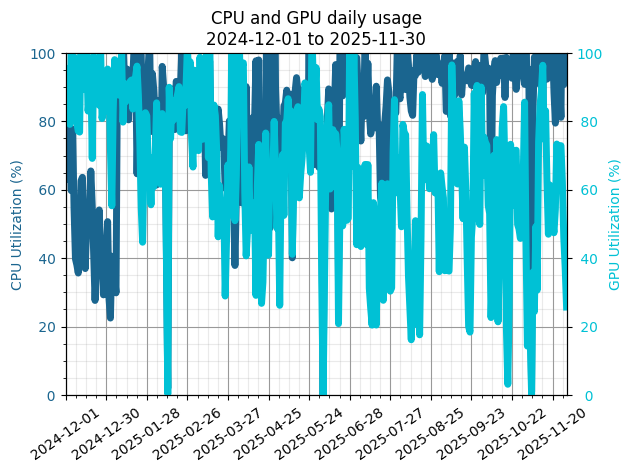

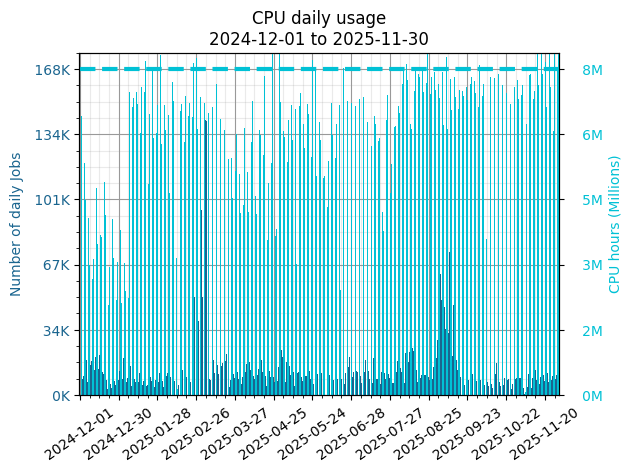

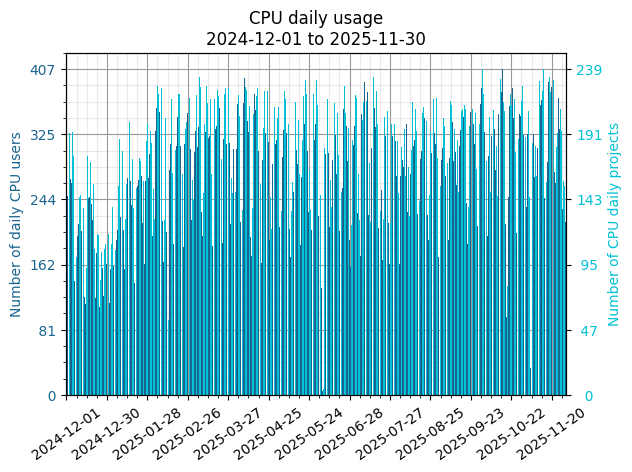

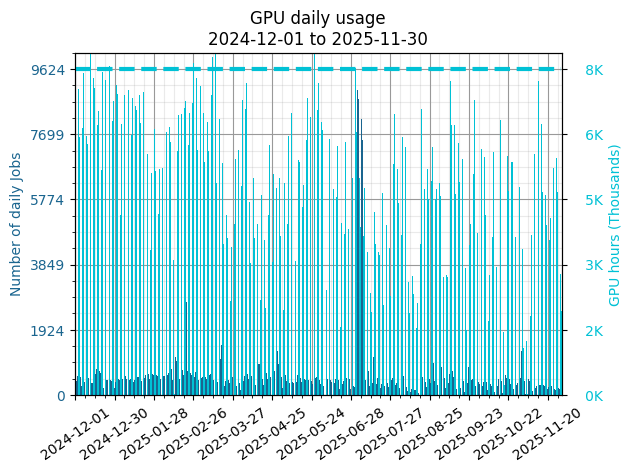

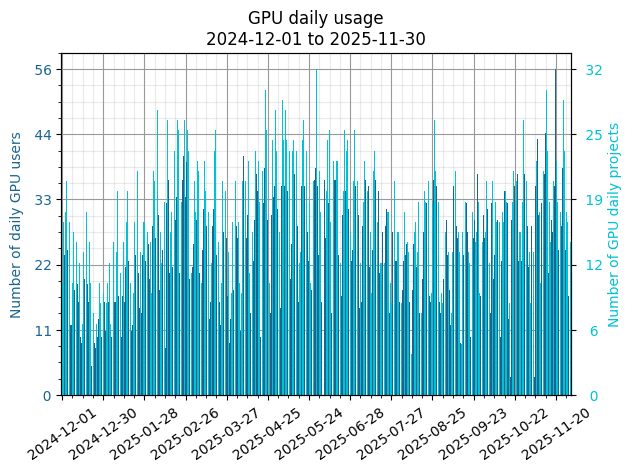

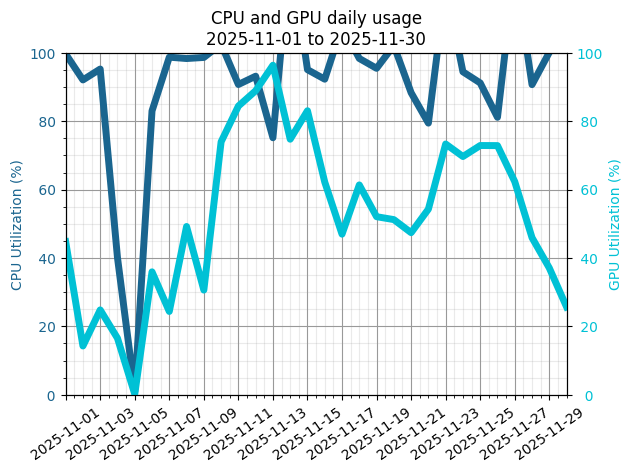

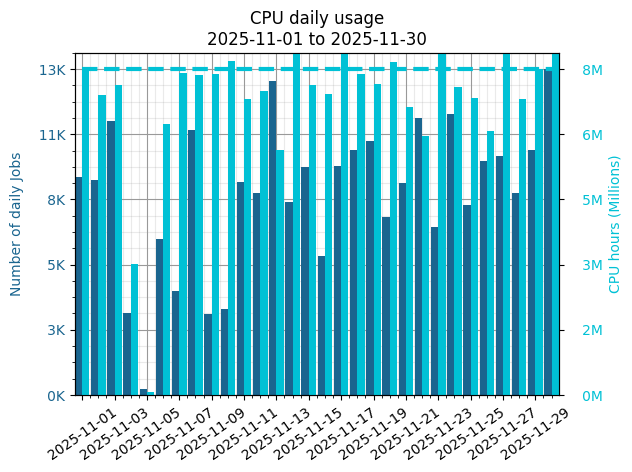

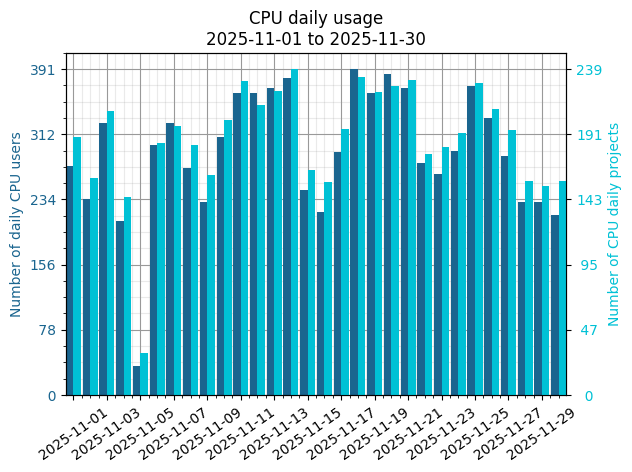

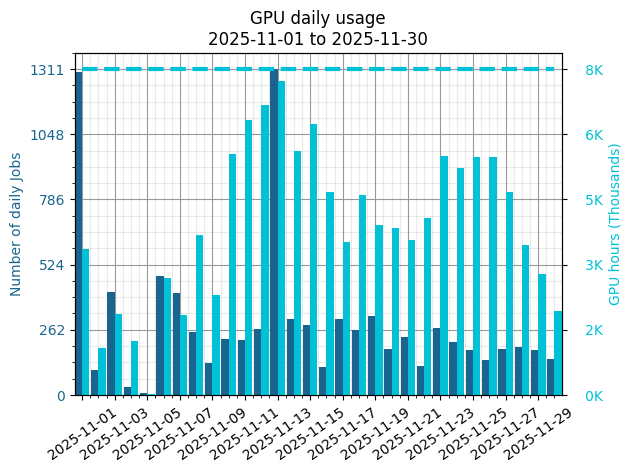

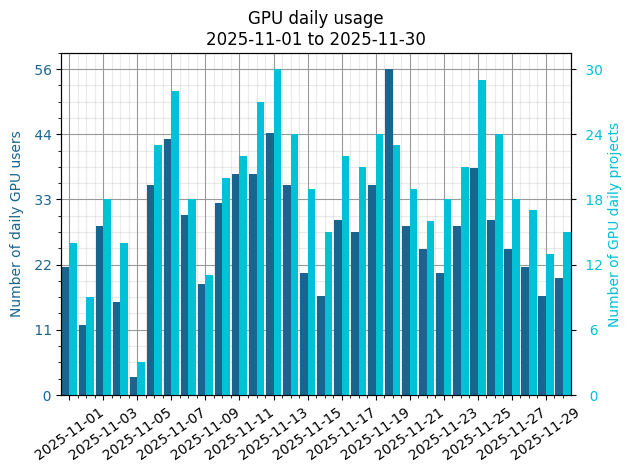

In [6]:
for f in glob.glob('*_usage_history*_*.dat'):
    print(f)
    co_plot_hours_history(f)
    
    #plot_hours_history(f,'cpu')
    plot_usage_history(f,'cpu')
    plot_user_history(f,'cpu')
    
    #plot_hours_history(f,'gpu')
    plot_usage_history(f, 'gpu')
    plot_user_history(f,'gpu')

In [7]:
# Resource histograms - hours

<>:12: SyntaxWarning: "\s" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\s"? A raw string is also an option.
<>:66: SyntaxWarning: "\s" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\s"? A raw string is also an option.
<>:12: SyntaxWarning: "\s" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\s"? A raw string is also an option.
<>:66: SyntaxWarning: "\s" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\s"? A raw string is also an option.
/var/folders/j1/l1rzmh5502nbv_bsgq5dx35c0000gr/T/ipykernel_32913/2564867960.py:12: SyntaxWarning: "\s" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\s"? A raw string is also an option.
  data = pd.read_csv(dfname, sep='\s+')
/var/folders/j1/l1rzmh5502nbv_bsgq5dx35c0000gr/T/ipykernel_32913/2564867960.py:66: SyntaxWarning: "\s" is an inval

De_cpu_job_sizes_2025-11-01_2025-11-30.dat
De_bycore_job_sizes_2025-11-01_2025-11-30.dat
De_gpu_job_sizes_2025-11-01_2025-11-30.dat
De_bycore_job_sizes_2024-12-01_2025-11-30.dat
De_gpu_job_sizes_2024-12-01_2025-11-30.dat
De_cpu_job_sizes_2024-12-01_2025-11-30.dat


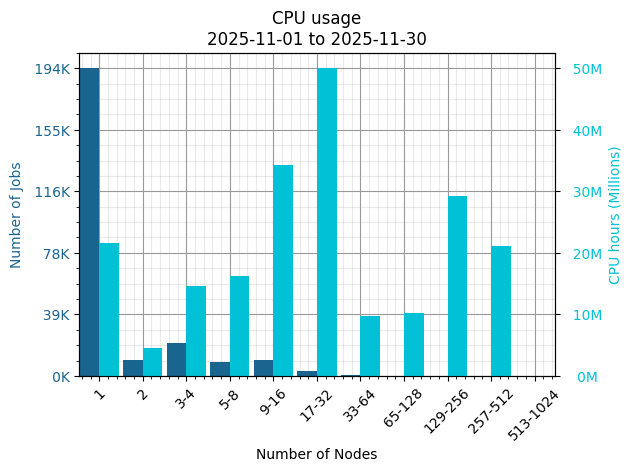

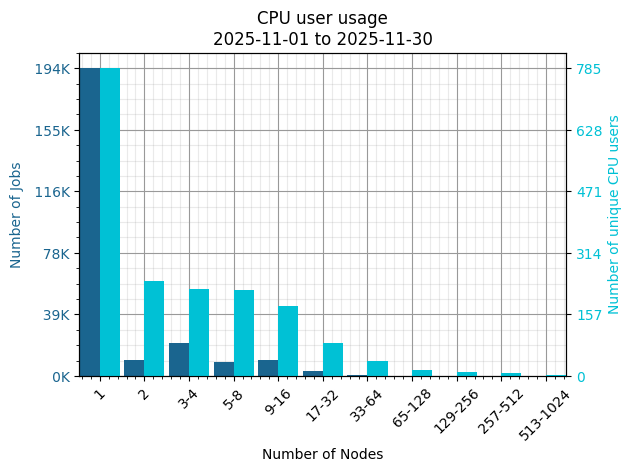

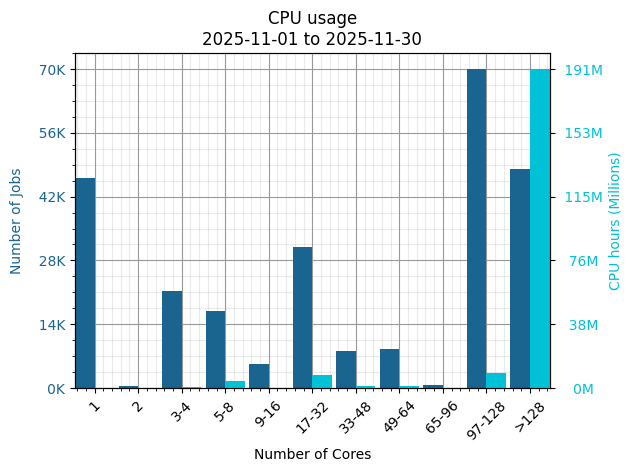

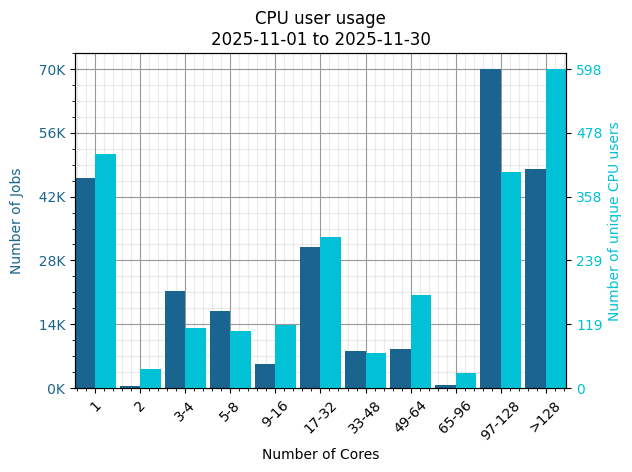

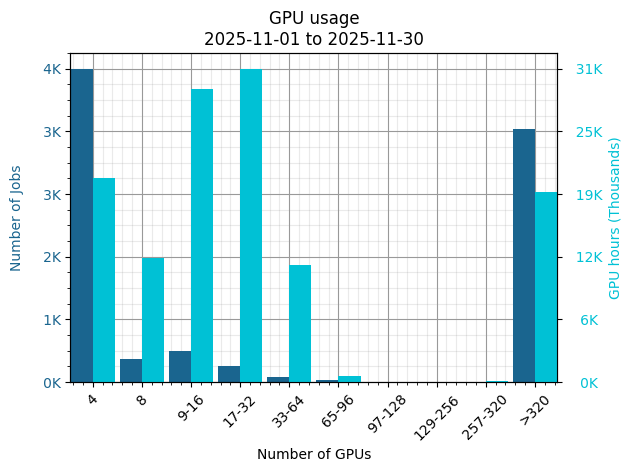

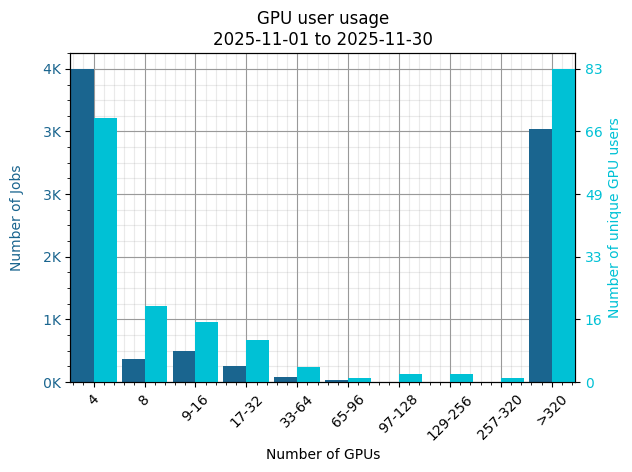

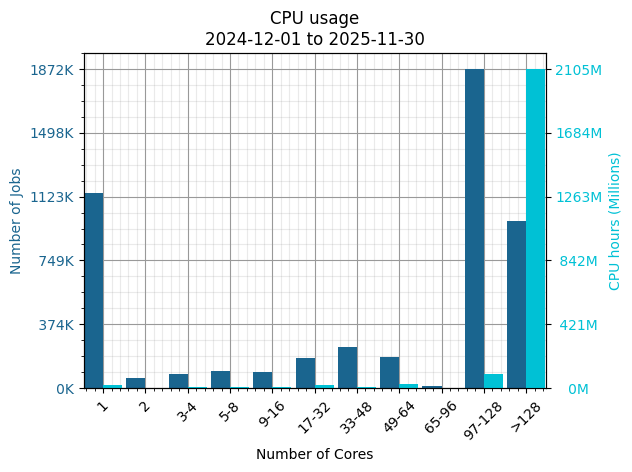

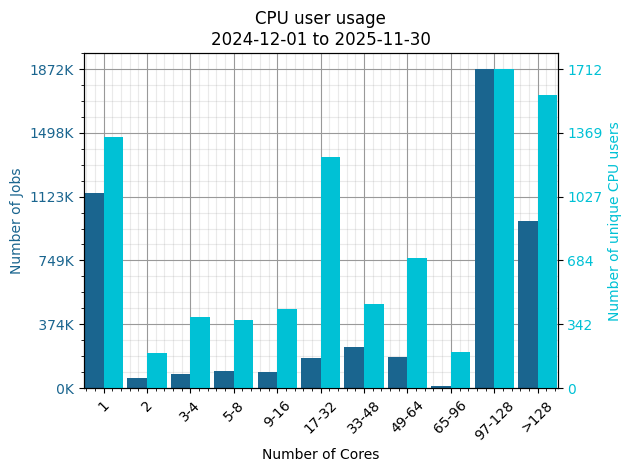

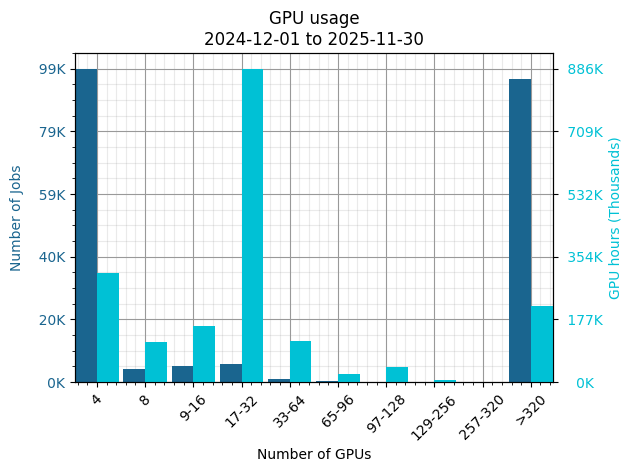

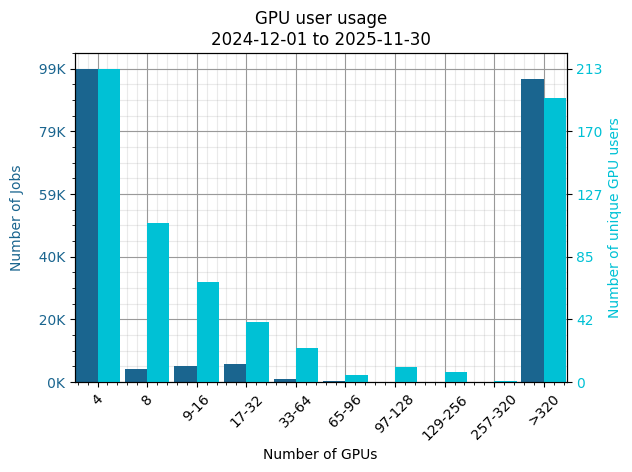

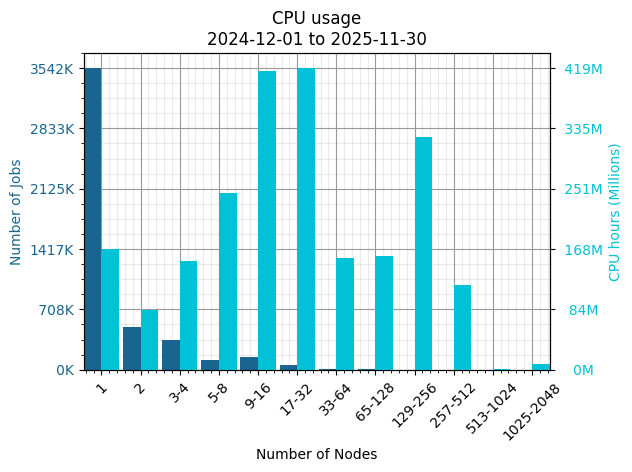

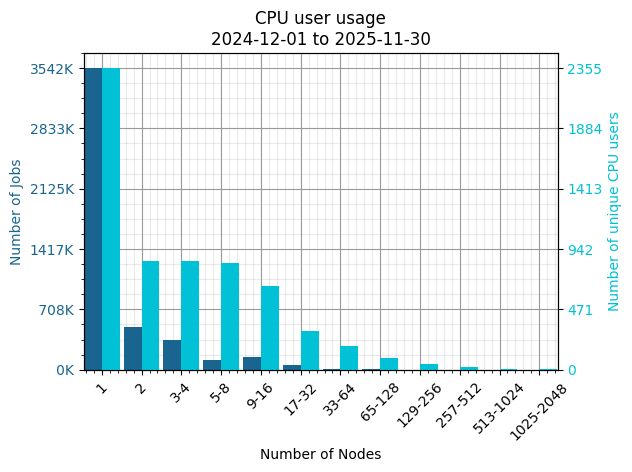

In [8]:
def plot_resource_histogram(filename):
 
    date_start, date_end = filename_to_date_range(filename)
    
    if 'gpu' in filename: type='gpu'
    elif 'bycore' in filename: type='cores'
    else: type='cpu' 

    set_norm_factors(type)
        
    dfname = filename
    data = pd.read_csv(dfname, sep='\s+')
    
    outfname = dfname[3:-4] + '.png'

    x = data.index.to_numpy()
    xl = data[label]
    y1 = data['#-Jobs']
    y2 = data['Cr-hrs']
    xl1 = []
    for e in xl:
       xl1.append(e)
    xl = np.array(xl1)
    y2 = y2 / normfactor

    f, ax1 = plt.subplots()
    format_ax(ax1)
    w = 0.45
    b1 = ax1.bar(x-w/2,y1,color=ncar_blue,width=w,zorder=2)
    plt.xlim([-1.02*w, max(x)+1.02*w])
    ax1.set_ylabel('Number of Jobs',color=ncar_blue)
    ax1.set_xlabel('Number of {}'.format(label))
    ax1.set_title('{} usage\n{} to {}'.format(hrtype,date_start,date_end))
    yt = np.linspace(0, max(y1), 6)
    yl = []
    for e in yt:
       yl.append('%4.0fK' % (e/1000))
    plt.yticks(yt,yl,color=ncar_blue)
    plt.xticks(x,xl,rotation=45)

    ax2 = ax1.twinx()
    yt = np.linspace(0, max(y2), 6)
    yl2 = []
    for e in yt:
       yl2.append('%4.0f{}'.format(hrsuffix) % (e))
    b2 = ax2.bar(x+w/2,y2,color=ncar_lightest_blue,width=w,zorder=2)
    ax2.set_ylabel('{} hours ({})'.format(hrtype,hrlabel),color=ncar_lightest_blue)
    plt.yticks(yt,yl2,color=ncar_lightest_blue)
    ax2.yaxis.tick_right()
    plt.tight_layout(pad=1)
    plt.savefig(outfname,dpi=mach['dpi'])
    plt.savefig(outfname.replace('.png','.pdf'))
    return

def plot_user_histogram(filename):
 
    date_start, date_end = filename_to_date_range(filename)
    
    if 'gpu' in filename: type='gpu'
    elif 'bycore' in filename: type='cores'
    else: type='cpu' 

    set_norm_factors(type)
        
    dfname = filename
    data = pd.read_csv(dfname, sep='\s+')
    
    outfname = dfname[3:-4] + '.png'
    outfname = outfname.replace('job_sizes','user_job_sizes')
    
    x = data.index.to_numpy()
    xl = data[label]
    y1 = data['#-Jobs']
    y2 = data['#-Users']
    xl1 = []
    for e in xl:
       xl1.append(e)
    xl = np.array(xl1)

    f, ax1 = plt.subplots()
    format_ax(ax1)
    w = 0.45
    b1 = ax1.bar(x-w/2,y1,color=ncar_blue,width=w,zorder=2)
    plt.xlim([-1.02*w, max(x)+1.02*w])
    ax1.set_ylabel('Number of Jobs',color=ncar_blue)
    ax1.set_xlabel('Number of {}'.format(label))
    ax1.set_title('{} user usage\n{} to {}'.format(hrtype,date_start,date_end))
    yt = np.linspace(0, max(y1), 6, dtype=np.uint32)
    yl = []
    for e in yt:
       yl.append('%4.0fK' % (e/1000))
    plt.yticks(yt,yl,color=ncar_blue)
    plt.xticks(x,xl,rotation=45)

    ax2 = ax1.twinx()
    yt = np.linspace(0, max(y2), 6)
    yl2 = []
    for e in yt:
       yl2.append(int(e))
    b2 = ax2.bar(x+w/2,y2,color=ncar_lightest_blue,width=w,zorder=2)
    ax2.set_ylabel('Number of unique {} users'.format(hrtype),color=ncar_lightest_blue)
    plt.yticks(yt,yl2,color=ncar_lightest_blue)
    ax2.yaxis.tick_right()
    plt.tight_layout(pad=1)
    plt.savefig(outfname,dpi=mach['dpi'])
    plt.savefig(outfname.replace('.png','.pdf'))
    return

for f in glob.glob('*_job_sizes*_*.dat'):
    print(f)
    plot_resource_histogram(f)
    plot_user_histogram(f)

# Resource histograms - wait times

<>:12: SyntaxWarning: "\s" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\s"? A raw string is also an option.
<>:12: SyntaxWarning: "\s" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\s"? A raw string is also an option.
/var/folders/j1/l1rzmh5502nbv_bsgq5dx35c0000gr/T/ipykernel_32913/2536783316.py:12: SyntaxWarning: "\s" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\s"? A raw string is also an option.
  data = pd.read_csv(dfname, sep='\s+')


De_cpu_job_waits_2024-12-01_2025-11-30.dat
De_bycore_job_waits_2024-12-01_2025-11-30.dat
De_gpu_job_waits_2024-12-01_2025-11-30.dat
De_bycore_job_waits_2025-11-01_2025-11-30.dat
De_gpu_job_waits_2025-11-01_2025-11-30.dat
De_cpu_job_waits_2025-11-01_2025-11-30.dat


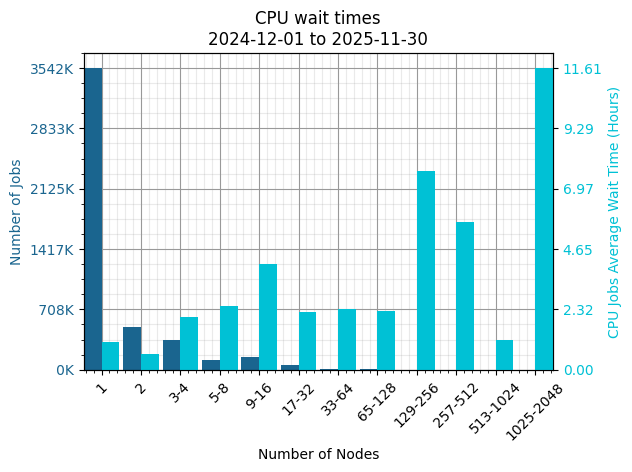

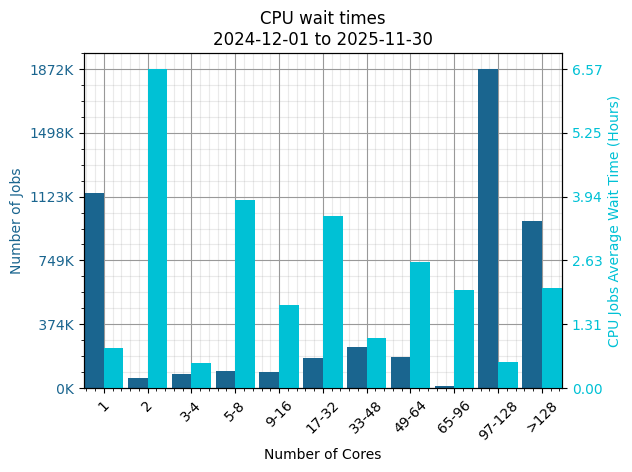

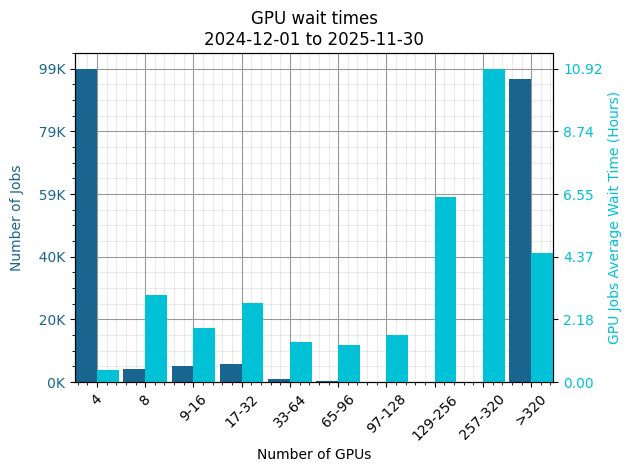

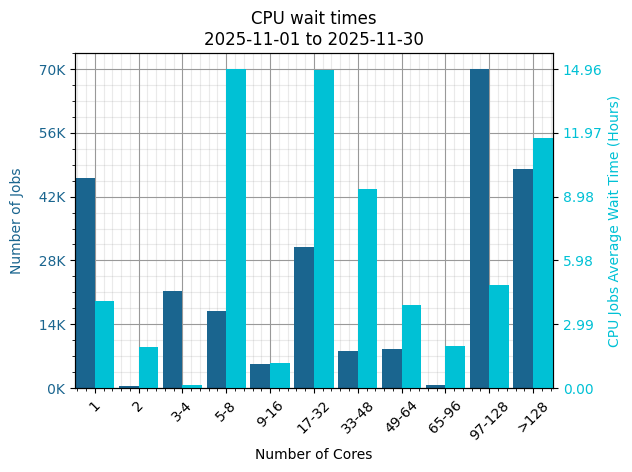

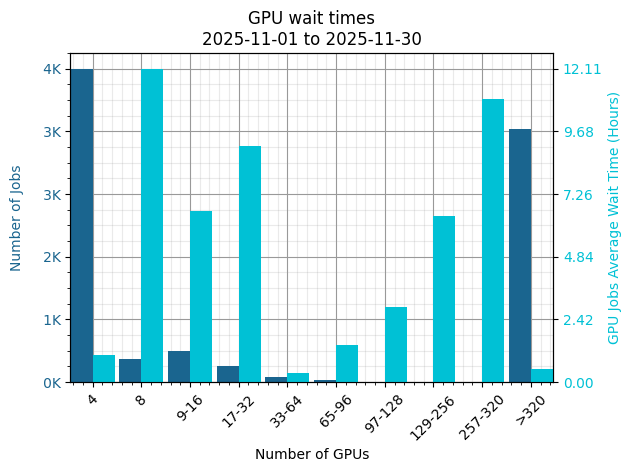

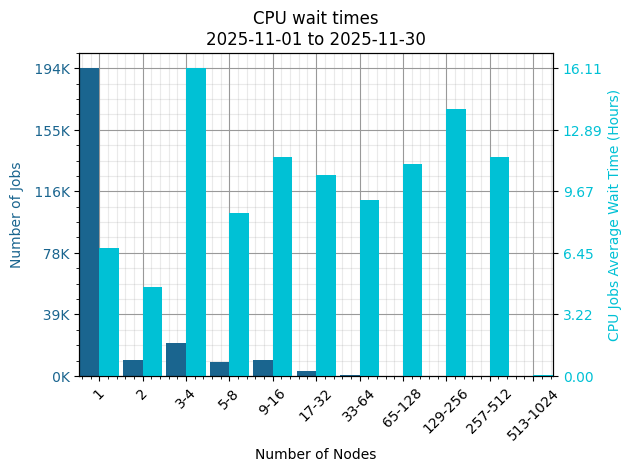

In [9]:
def plot_wait_histogram(filename):
 
    date_start, date_end = filename_to_date_range(filename)
    
    if 'gpu' in filename: type='gpu'
    elif 'bycore' in filename: type='cores'
    else: type='cpu' 

    set_norm_factors(type)
        
    dfname = filename
    data = pd.read_csv(dfname, sep='\s+')
    
    outfname = dfname[3:-4] + '.png'

    x = data.index.to_numpy()
    xl = data[label]
    y1 = data['#-Jobs']
    y2 = data['AveWait-hrs']
    xl1 = []
    for e in xl:
       xl1.append(e)
    xl = np.array(xl1)

    f, ax1 = plt.subplots()
    format_ax(ax1)
    w = 0.45
    b1 = ax1.bar(x-w/2,y1,color=ncar_blue,width=w,zorder=2)
    plt.xlim([-1.02*w, max(x)+1.02*w])
    ax1.set_ylabel('Number of Jobs',color=ncar_blue)
    ax1.set_xlabel('Number of {}'.format(label))
    ax1.set_title('{} wait times\n{} to {}'.format(hrtype,date_start,date_end))
    yt = np.linspace(0, max(y1), 6)
    yl = []
    for e in yt:
       yl.append('%4.0fK' % (e/1000))
    plt.yticks(yt,yl,color=ncar_blue)
    plt.xticks(x,xl,rotation=45)

    ax2 = ax1.twinx()
    yt = np.linspace(0, max(y2), 6)
    yl2 = []
    for e in yt:
       yl2.append('{:.2f}'.format(e))
    b2 = ax2.bar(x+w/2,y2,color=ncar_lightest_blue,width=w,zorder=2)
    ax2.set_ylabel('{} Jobs Average Wait Time (Hours)'.format(hrtype),color=ncar_lightest_blue)
    plt.yticks(yt,yl2,color=ncar_lightest_blue)
    ax2.yaxis.tick_right()
    plt.tight_layout(pad=1)
    plt.savefig(outfname,dpi=mach['dpi'])
    plt.savefig(outfname.replace('.png','.pdf'))
    return


for f in glob.glob('*_job_waits*_*.dat'):
    print(f)
    plot_wait_histogram(f)

# Usage pie charts

<>:21: SyntaxWarning: "\s" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\s"? A raw string is also an option.
<>:21: SyntaxWarning: "\s" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\s"? A raw string is also an option.
/var/folders/j1/l1rzmh5502nbv_bsgq5dx35c0000gr/T/ipykernel_32913/3465559096.py:21: SyntaxWarning: "\s" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\s"? A raw string is also an option.
  data = pd.read_csv(dfname, sep='\s+')


De_pie_group_gpu_2025-11-01_2025-11-30.dat
De_pie_proj_gpu_2025-11-01_2025-11-30.dat
De_pie_proj_gpu_2024-12-01_2025-11-30.dat
De_pie_group_gpu_2024-12-01_2025-11-30.dat
De_pie_group_cpu_2025-11-01_2025-11-30.dat
De_pie_proj_cpu_2025-11-01_2025-11-30.dat
De_pie_proj_cpu_2024-12-01_2025-11-30.dat
De_pie_group_cpu_2024-12-01_2025-11-30.dat
De_pie_user_gpu_2025-11-01_2025-11-30.dat
De_pie_user_gpu_2024-12-01_2025-11-30.dat
De_pie_user_cpu_2025-11-01_2025-11-30.dat
De_pie_user_cpu_2024-12-01_2025-11-30.dat


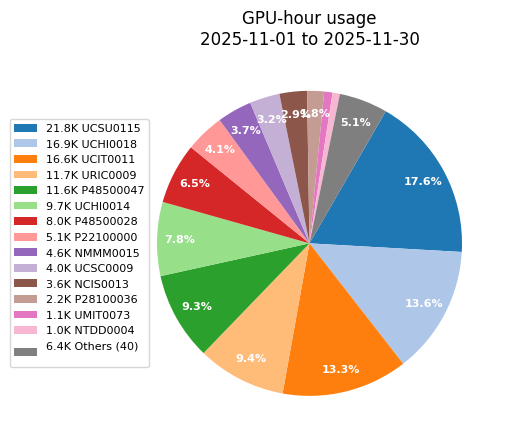

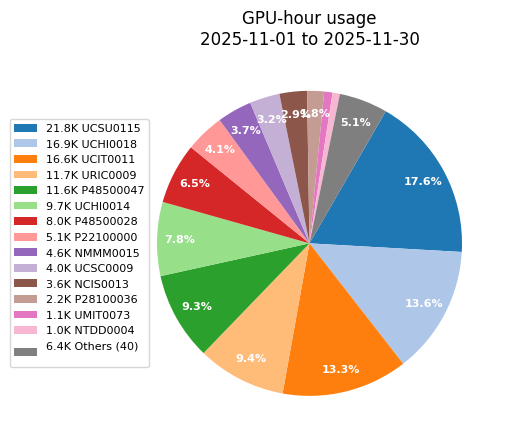

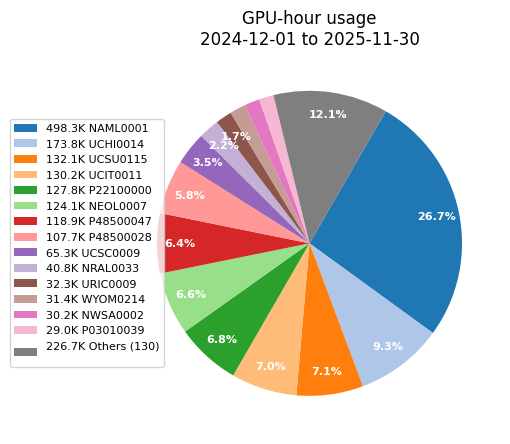

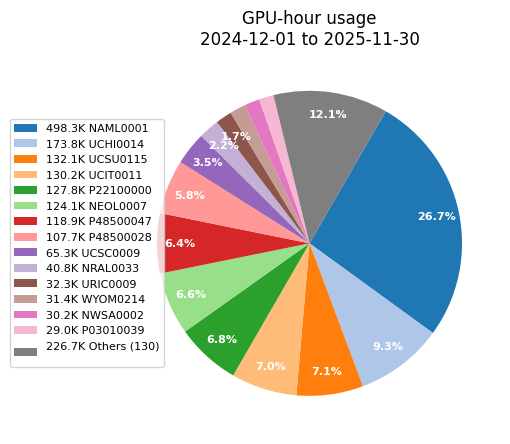

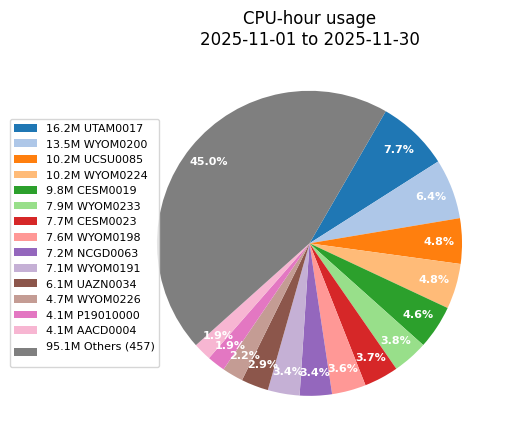

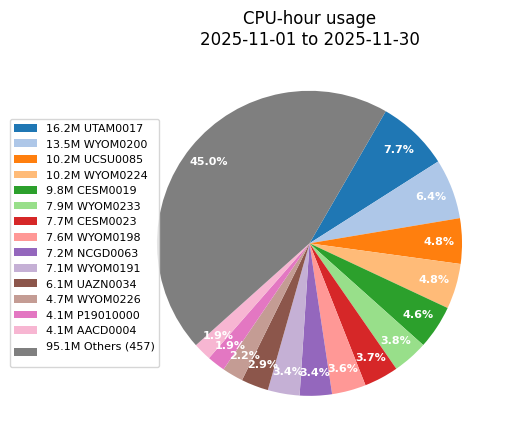

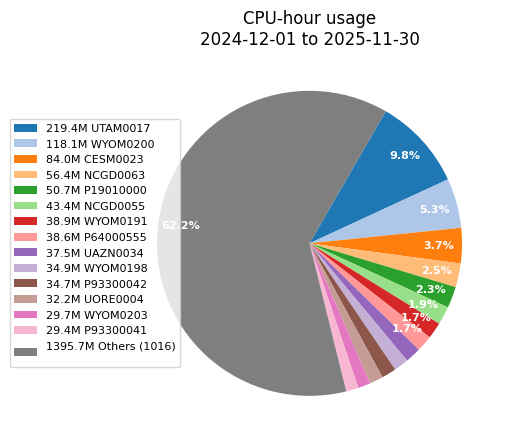

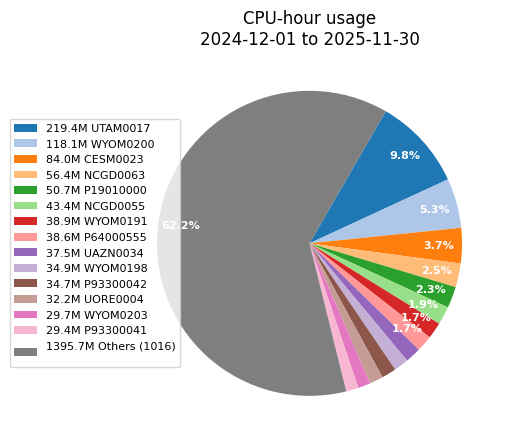

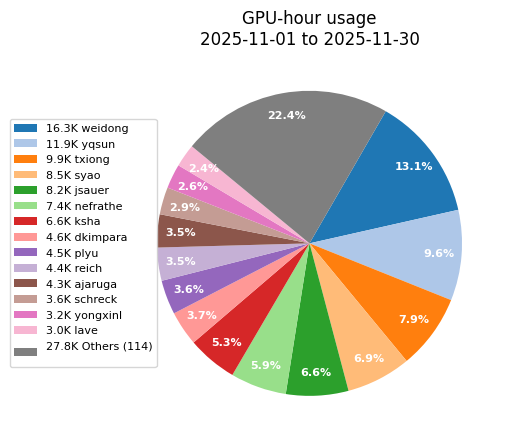

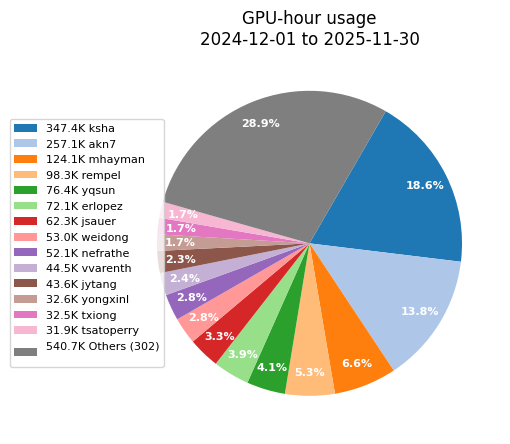

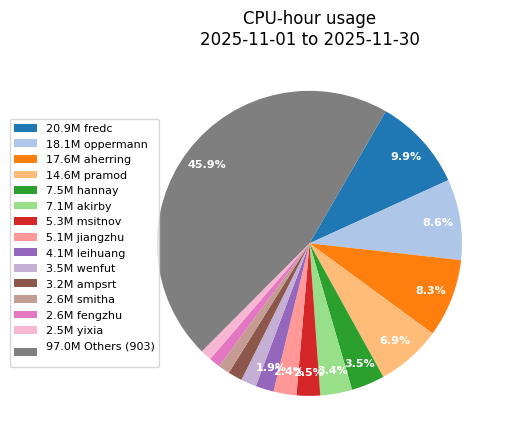

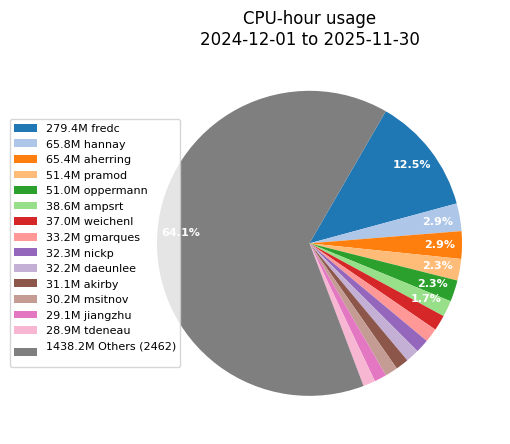

In [10]:
def conv2Nicedate( raw ):
   yr = raw[:4]; mn = raw[4:6]; day = raw[6:]
   return '-'.join([yr,mn,day])
 
def absolute_value(val):
    if (val < 1.7): 
       return None
    else:
       return '{p:.1f}%'.format(p=val)

def plot_usage_pie(filename):
    
    date_start, date_end = filename_to_date_range(filename)
    
    if 'gpu' in filename: type='gpu'
    else: type='cpu' 
    
    set_norm_factors(type)
        
    dfname = filename
    data = pd.read_csv(dfname, sep='\s+')
    outfname = dfname[3:-4] + '.png'

    angle = 60
    if len(sys.argv) == 4:
       angle = int(sys.argv[3])

    maxentity = 14
    if len(sys.argv) == 5:
       maxentity = int(sys.argv[4])

    nrows = len(data.index)
    keys = data.keys()
    if nrows > maxentity:
       nu = np.min([maxentity,nrows])
       usg = np.concatenate((data['Usage'][:nu], [np.sum(data['Usage'][nu:])]))
       others = 'Others (' + str(nrows - maxentity) + ')\n'
       names = np.concatenate((data[keys[0]][:nu], [others]))
    else:
       usg = data['Usage']
       names = data[keys[0]]
    labels = []
    for i, e in enumerate(usg):
       labels.append('{v:.1f}{l} {n:s}'.format(v=e/normfactor, l=hrsuffix, n=names[i]))

    fig = plt.figure()

    with plt.style.context({"axes.prop_cycle" : plt.cycler("color", plt.cm.tab20.colors)}):
        ax = fig.add_subplot(aspect="equal")
        patches, texts, autotexts = ax.pie(usg, labels=None, startangle=angle, 
                                       counterclock=False, autopct=absolute_value, pctdistance=0.85 )
        ax.set_title('{}-hour usage\n{} to {}'.format(hrtype,date_start,date_end))
        plt.setp(autotexts, **{'color':'white', 'weight':'bold', 'fontsize':8})
        plt.setp(texts, **{'fontsize':8})
        plt.legend(patches, labels, loc='center left', bbox_to_anchor=(-0.3, .5), fontsize=8)
        plt.tight_layout(pad=2)
        plt.savefig(outfname,dpi=mach['dpi'])
        plt.savefig(outfname.replace('.png','.pdf'))
    return

for f in glob.glob('*_pie_*_*_*.dat'):
    print(f)
    plot_usage_pie(f)

# Job Durations

<>:11: SyntaxWarning: "\s" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\s"? A raw string is also an option.
<>:11: SyntaxWarning: "\s" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\s"? A raw string is also an option.
/var/folders/j1/l1rzmh5502nbv_bsgq5dx35c0000gr/T/ipykernel_32913/1495009690.py:11: SyntaxWarning: "\s" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\s"? A raw string is also an option.
  data = pd.read_csv(dfname, sep='\s+')


De_gpu_job_durations_2024-12-01_2025-11-30.dat
De_gpu_job_durations_2025-11-01_2025-11-30.dat
De_cpu_job_durations_2025-11-01_2025-11-30.dat
De_cpu_job_durations_2024-12-01_2025-11-30.dat


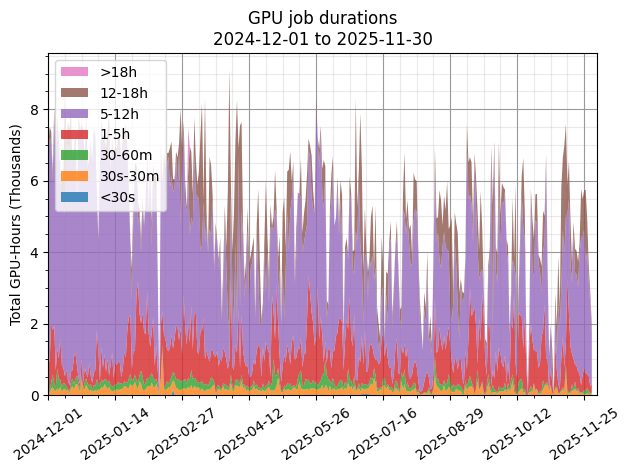

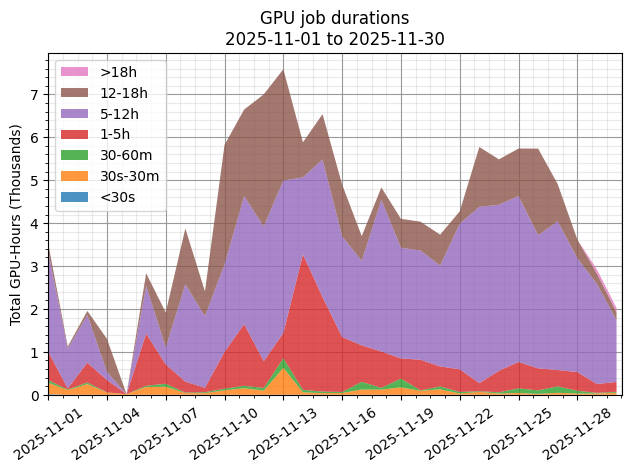

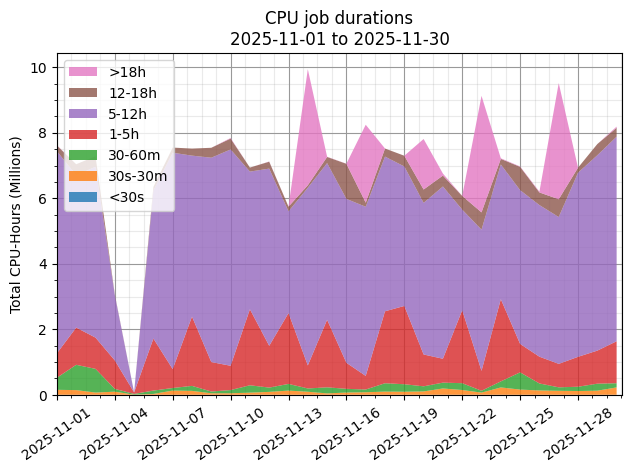

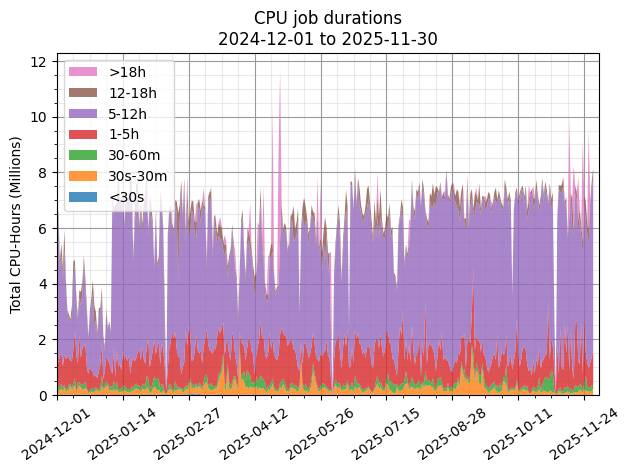

In [11]:
def plot_job_durations(filename):
 
    date_start, date_end = filename_to_date_range(filename)

    if 'gpu' in filename: type='gpu'
    else: type='cpu' 
    
    set_norm_factors(type)
        
    dfname = filename
    data = pd.read_csv(dfname, sep='\s+')
    outfname = dfname[3:-4] + '.png'
    x = data.index.to_numpy()
    xl = data['Date']
    cols = data.keys()[1:]
    ncols = len(cols)
    y = []
    for col in cols:
       y.append(data[col])
    y = np.array(y) / normfactor

    f, ax = plt.subplots()
    format_ax(ax)
    ax.stackplot(x,y,labels=cols, zorder=2,alpha=0.8)
    plt.xlim([0, 1.01*max(x)])
    #plt.legend(loc='lower left')
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], loc='upper left')
    nxtks = 8
    n = len(xl)
    nd = int(n/nxtks)
    plt.xticks(x[0:n:nd],xl[0:n:nd],rotation=35)
    plt.ylabel('Total {}-Hours ({})'.format(hrtype,hrlabel))
    ax.set_title('{} job durations\n{} to {}'.format(hrtype,date_start,date_end))
    plt.tight_layout(pad=1)
    plt.savefig(outfname,dpi=mach['dpi'])
    plt.savefig(outfname.replace('.png','.pdf'))
    return

for f in glob.glob('*_job_durations*_*.dat'):
    print(f)
    plot_job_durations(f)